<h2>Prototype</h2>

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import get_window
from scipy.io import wavfile
from scipy.signal import savgol_filter
from scipy.signal import wiener
import IPython

In [65]:
fs, x = wavfile.read("samples/tu-jesty.wav")
x = x / np.max(abs(x))

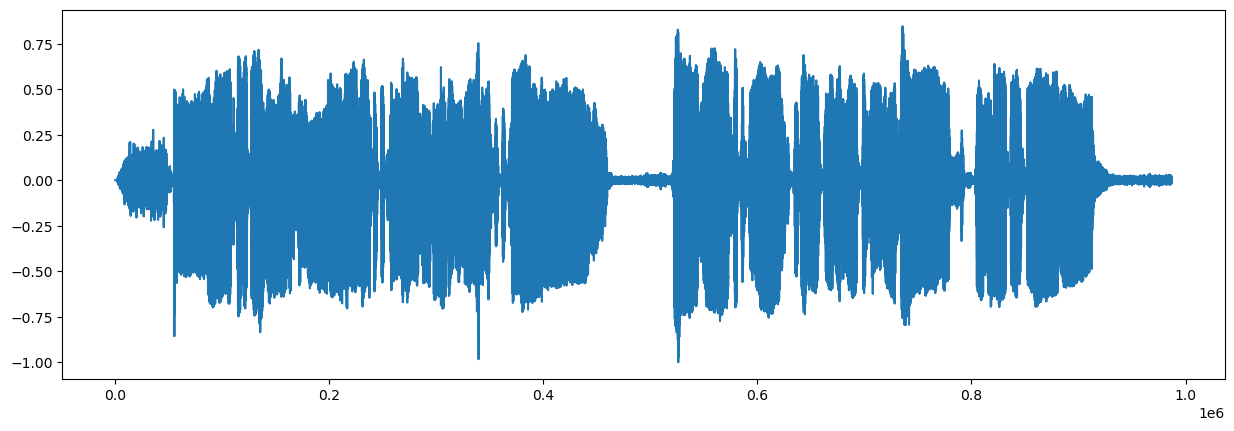

In [66]:
plt.figure().set_figwidth(15)
plt.plot(x)
IPython.display.Audio(x, rate=fs)

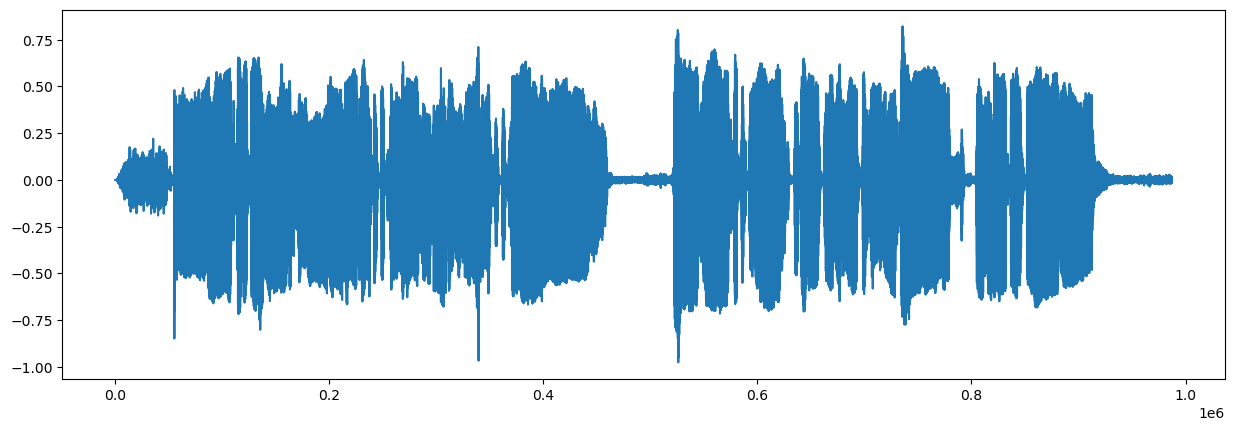

In [67]:
x = wiener(x, mysize=10)

plt.figure().set_figwidth(15)
plt.plot(x)
IPython.display.Audio(x, rate=fs)

In [68]:
M=8191
N=8192
H=1024

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [69]:
w  = get_window('hamming', M)
w = w / sum(w)

In [70]:
def computeSpectrum(x):
    spectrum = []
    Mspec = []
    onset = []
    l = 0
    while l < len(x) - M:
        y = x[l: l + M]
        rmsframe = np.sqrt(np.dot(y, y) / M)    
        
        if rmsframe > 0.1: 
            y = y / np.max(abs(y))
            y = y * w

            fftBuffer = np.zeros(N)
            fftBuffer[: hM1] = y[hM2:] 
            fftBuffer[N - hM2:] = y[: hM2]

            X = fft(fftBuffer)
            absX = abs(X)
            absX[absX < np.finfo(float).eps] = np.finfo(float).eps
            mX = 10 * np.log10(absX)
            spectrum.append(mX)
            Mspec.append(absX)
            
            power = 0
            for k in range(1, len(absX)):
                power += absX[k] * absX[k]
            onset.append(power)

        l += H
    
    return spectrum, Mspec, onset

In [71]:
spectrum, Mspec, onset = computeSpectrum(x)

In [72]:
t = np.arange(len(spectrum)) * H / fs
fqs = np.arange(N) * fs / N
f = int(1000 * N / fs)

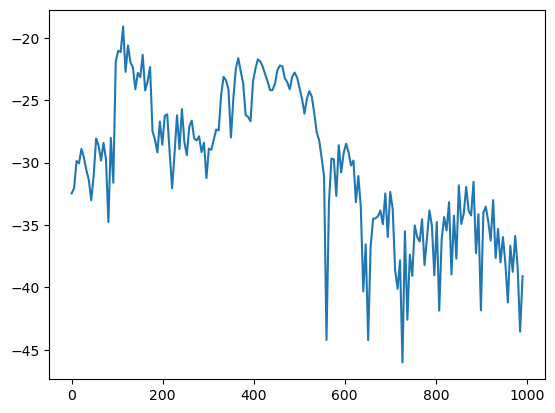

In [73]:
plt.plot(fqs[:f], spectrum[0][:f])

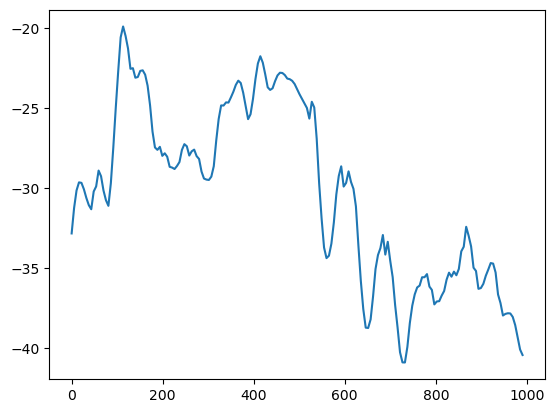

In [74]:
filtered = savgol_filter(spectrum[0][:f], 15, 5)
plt.plot(fqs[:f], filtered)

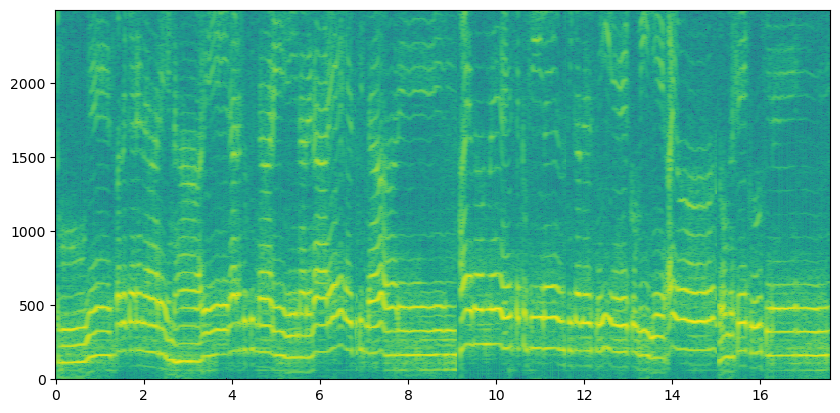

In [75]:
f = int(2500 * N / fs)
spectrum = np.array(spectrum)
plt.figure().set_figwidth(10)
fqs = np.arange(N) * fs / N
plt.pcolormesh(t, fqs[:f], spectrum.T[:f])

In [76]:
centroid = []

for spec in Mspec:
    ck = 0
    for i in range(1, len(spec[:int(N/2)])):
        ck += i * spec[i]
    centroid.append(ck / sum(spec[1:int(N/2)]))

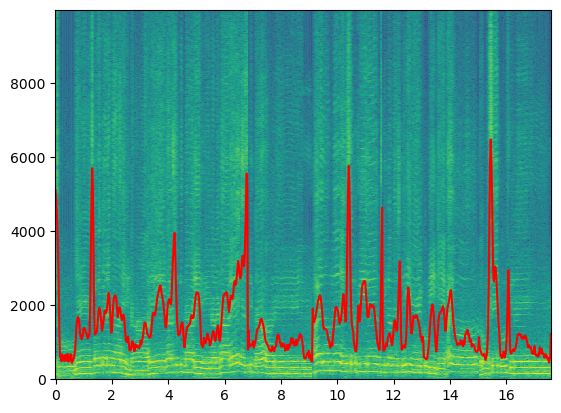

In [77]:
plt.pcolormesh(t, fqs[:int(10000 * N / fs)], spectrum.T[:int(10000 * N / fs)])
plt.plot(t, [i * fs / N for i in centroid], c='r')

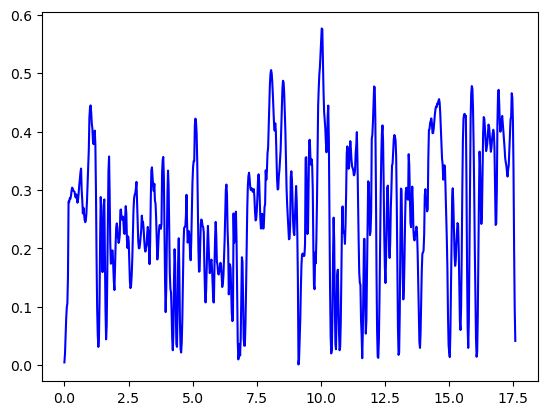

In [78]:
plt.plot(t, onset, c='b')

In [79]:
peakFrqs = []
peakMags = []

for i in range(len(spectrum)):
    mX = savgol_filter(spectrum[i][:f], 15, 5)
    peaks = []
    mags = []
    k = 15

    while k < len(mX) - 1:
        if len(peaks) == 8:
                break
        if mX[k] < -25: 
            k += 1
            continue

        if mX[k-1] < mX[k] and mX[k] > mX[k+1]:
            tmp = np.zeros(len(mX)) - 100
            tmp[k:k+15] = mX[k:k+15]
            peaks.append(np.argmax(tmp) * fs / N)
            mags.append(mX[np.argmax(tmp)])
            k = np.argmax(tmp) + 5
        else: k += 1

    peakFrqs.append(peaks)
    peakMags.append(mags)

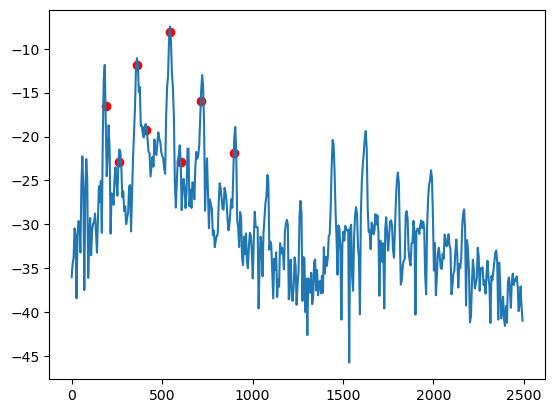

In [80]:
plt.plot(fqs[:f], spectrum[200][:f])
plt.scatter(peakFrqs[200], peakMags[200], c='r')

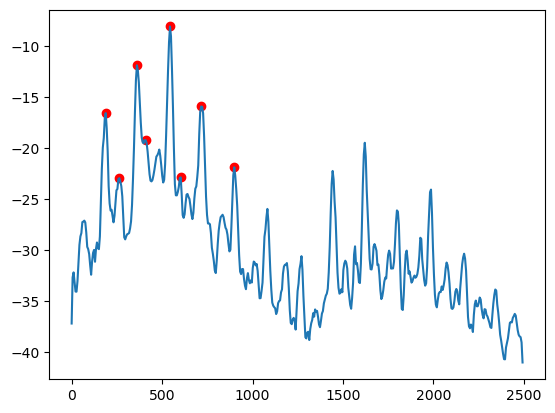

In [81]:
plt.plot(fqs[:f], savgol_filter(spectrum[200][:f], 15, 5))
plt.scatter(peakFrqs[200], peakMags[200], c='r')

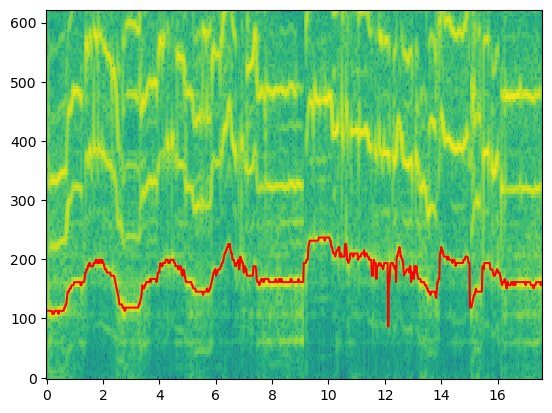

In [82]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, [i[0] for i in peakFrqs], c='r')

In [83]:
fundamentals = []
for i in range(len(peakFrqs)):
    candidates = []
    
    for j in range(len(peakFrqs[i]) - 1):
        #print(peaks_k[i][j+1] - peaks_k[i][j])
        temp = peakFrqs[i][j+1] - peakFrqs[i][j]
        if temp > 100 and temp < 255:
            candidates.append(peakFrqs[i][j+1] - peakFrqs[i][j])
        
    if len(candidates) == 0: f0 = 100
    else: 
        f0 = candidates[0]
        least_err = 99999

        for c in candidates:
            #print("Candidate: {}".format(c))
            if c < 80: continue
            errpm = 0
            errmp = 0

            k = 1
            overtone = c
            predicted = []

            while overtone < peakFrqs[i][-1] + c:
                predicted.append(overtone)
                overtone += c

            for j in range(len(peakFrqs[i])):
                closestHarm = predicted[np.abs(predicted - peakFrqs[i][j]).argmin()]
                #print("measured: {}".format(peakFrqs[i][j]), end='')
                #print(", predicted: {}".format(closestHarm))

                errpm += (closestHarm - peakFrqs[i][j]) * (closestHarm)**(-0.5) + peakMags[i][j] / (max(peakMags[i]) - 0.01) * (1.4 * (closestHarm - peakFrqs[i][j]) * (closestHarm)**(-0.5) - 0.5)
                errmp += (closestHarm - peakFrqs[i][j]) * (peakFrqs[i][j])**(-0.5) + peakMags[i][j] / (max(peakMags[i]) - 0.01) * (1.4 * (closestHarm - peakMags[i][j]) * (peakFrqs[i][j])**(-0.5) - 0.5)

            err_tot = (errpm + errmp) / len(peakFrqs[i])
            if err_tot < least_err:
                least_err = err_tot
                f0 = c
    
    fundamentals.append(f0)
len(fundamentals)

758

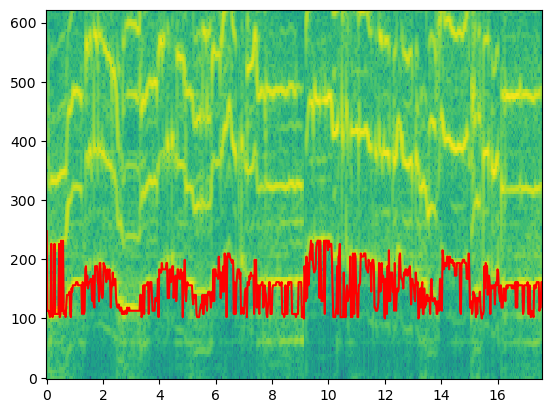

In [84]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, fundamentals, c='r')

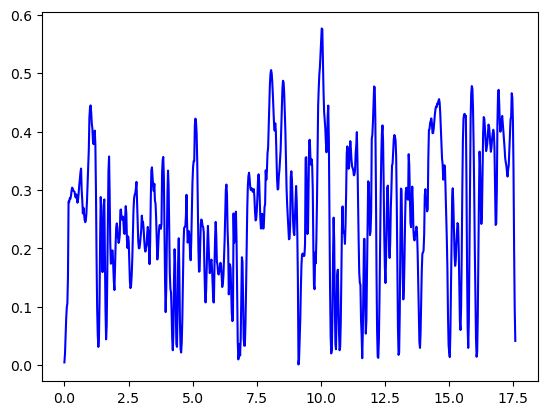

In [85]:
plt.plot(t, onset, c='b')

<h4>Needs a nueral network to identify the peaks</h4>

In [86]:
#notes = np.round([69 + 12 * np.log2((f0 + 0.0001) / 440) for f0 in fundamentals if f0 is not None]).tolist()
notes = np.round([69 + 12 * np.log2((f0 + 0.0001) / 440) for f0 in [i[0] for i in peakFrqs]]).tolist()

notestoFreqs = [440 * (2 ** ((i - 69) / 12)) for i in notes] 

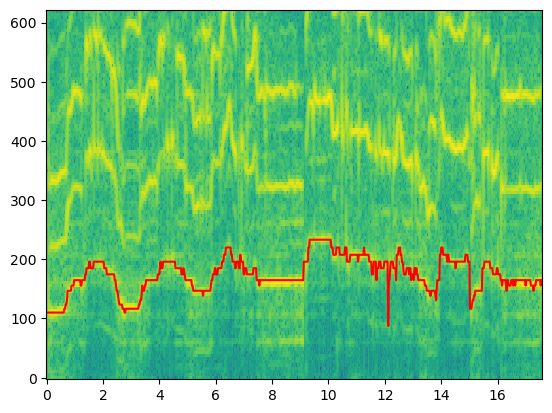

In [87]:
plt.pcolormesh(t, fqs[:f//4], spectrum.T[:f//4])
plt.plot(t, notestoFreqs, c='r')

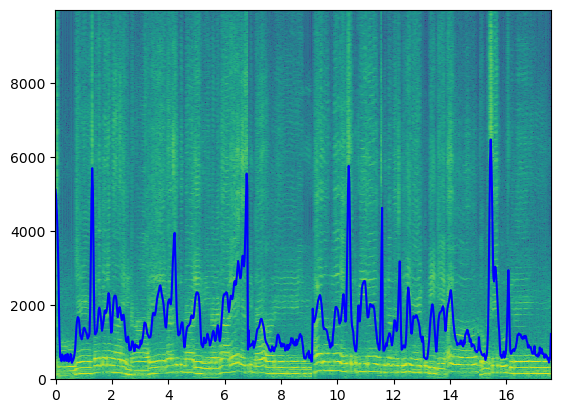

In [88]:
plt.pcolormesh(t, fqs[:int(10000 * N / fs)], spectrum.T[:int(10000 * N / fs)])
plt.plot(t, [i * fs / N for i in centroid], c='b')

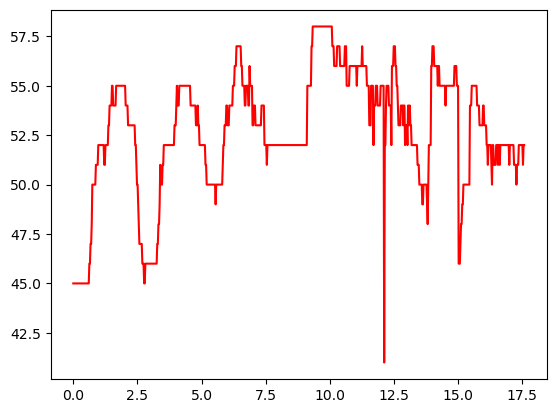

In [89]:
plt.plot(t, notes, c='r')

In [90]:
import json

In [91]:
tujesty = []
talasaki = []

with open('tu-jesty.json', 'r') as fp:
    tujesty = json.load(fp)['melody']
    
with open('talasaki.json', 'r') as fp:
    talasaki = json.load(fp)['melody']
    
tujesty = (np.array(tujesty) - np.mean(tujesty)).tolist()
talasaki = (np.array(talasaki) - np.mean(talasaki)).tolist()
notes = (np.array(notes) - np.mean(notes)).tolist()

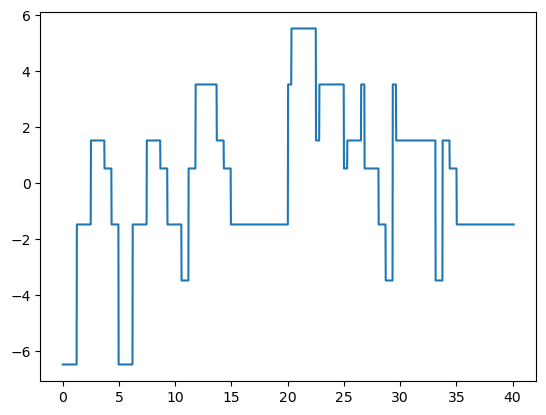

In [92]:
mt1 = np.arange(len(tujesty)) * H / fs
plt.plot(mt1, tujesty)

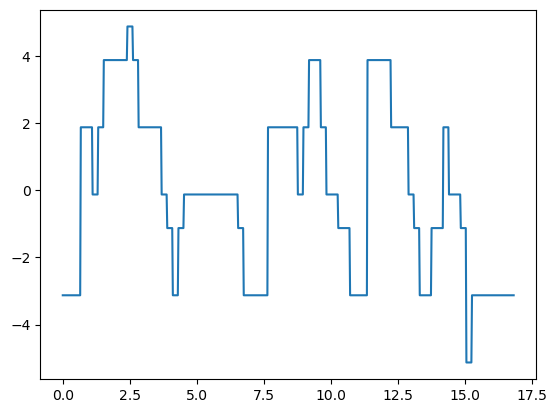

In [93]:
mt2 = np.arange(len(talasaki)) * H / fs
plt.plot(mt2, talasaki)

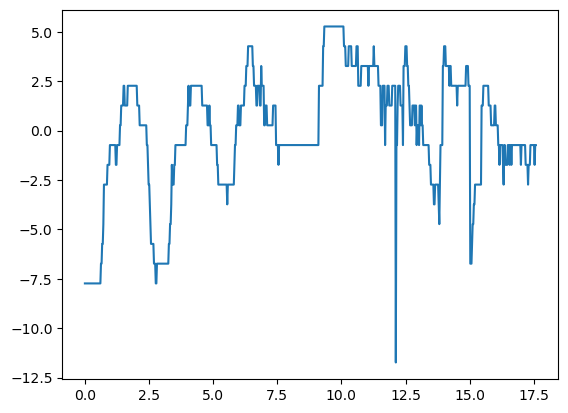

In [94]:
plt.plot(t, notes)

In [95]:
stddeviations = []
for i in range(len(notes)):
    if i < 5:
        stddeviations.append(np.std(notes[0:i + 1]))
    else:
        stddeviations.append(np.std(notes[i - 3: i + 1]))

In [96]:
stableNotes = []
for i in range(len(stddeviations)):
    if stddeviations[i] < 1:
        stableNotes.append(notes[i]);

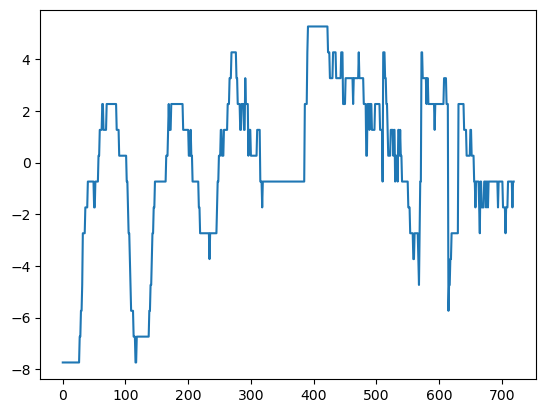

In [97]:
plt.plot(stableNotes)

In [98]:
from fastdtw import fastdtw

In [99]:
distancetujesty, path = fastdtw(stableNotes, tujesty)
distancetalasaki, path = fastdtw(stableNotes, talasaki)

print(f"Distance tujesty: {distancetujesty}")
print(f"Distance talasaki: {distancetalasaki}")

Distance tujesty: 870.2950167350795
Distance talasaki: 1326.9266556183293


In [100]:
if distancetujesty < distancetalasaki:
    print('The song is tu jesty fata')
else:
    print('The song is talasaki')

The song is tu jesty fata
